# Subclassing Bijectors

> In this post, we are going to make customized transformation with our own bijectors for fexibility. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/learned_dist.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

We can create our bijector by using bijector subclassing.

### Sample bijector

In [3]:
class MySigmoid(tfb.Bijector):
    def __init__(self, validate_args=False, name='sigmoid'):
        super(MySigmoid, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self, x):
        return tf.math.sigmoid(x)
    
    def _inverse(self, y):
        return tf.math.log(y) - tf.math.log(1 - y)
    
    def _inverse_log_det_jacobian(self, y):
        return -tf.math.log(y) - tf.math.log(1 - y)
    
    def _forward_log_det_jacobian(self, x):
        return -self.inverse_log_det_jacobian(self._forward(x))

Note that, while implementing our bijector, the name of method should contain underscore in front of the name itself.

### Same bijector (implementing forward log det jacobian)

In [4]:
class MySigmoid(tfb.Bijector):
    def __init__(self, validate_args=False, name='sigmoid'):
        super(MySigmoid, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self, x):
        return tf.math.sigmoid(x)
    
    def _inverse(self, y):
        return tf.math.log(y) - tf.math.log(1 - y)
    
    def _inverse_log_det_jacobian(self, y):
        return -_forward_log_det_jacobian(self._inverse(y))
    
    def _forward_log_det_jacobian(self, x):
        return -tf.math.softplus(-x) - tf.math.softplus(x)

### Simple shift bijector

In [5]:
class MyShift(tfb.Bijector):
    def __init__(self, shift, validate_args=False, name='shift'):
        self.shift = shift
        super(MyShift, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name, is_constant_jacobian=True)
        
    def _forward(self, x):
        return x + self.shift
    
    def _inverse(self, y):
        return y - self.shift
    
    def _forward_log_det_jacobian(self, x):
        return tf.constant(0., x.dtype)

### Simple Tanh bijector

In [7]:
class MyTanh(tfb.Bijector):
    
    def __init__(self, validate_args=False, name='cube'):
        super(MyTanh, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        return tf.math.tanh(x)

    def _inverse(self, y):
        return tf.math.atanh(y)
    
    def _forward_log_det_jacobian(self, x):
        return tf.math.log1p(-tf.square(tf.tanh(x)))

## Tutorial

In [12]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):
    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
            
        super(Cubic, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))
        
    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

In [13]:
# Cubic bijector

cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [14]:
# Apply forward transformation

x = tf.constant([[1, 2], [3, 4]])
y = cubic.forward(x)
y

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[   0.     ,  -46.656  ],
       [   8.     , -438.97598]], dtype=float32)>

In [16]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

### Function plots

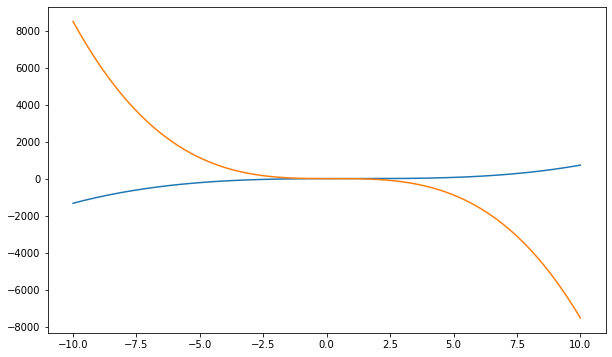

In [17]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))
plt.show()

In [18]:
# Display shape
cubic.forward(x).shape

TensorShape([500, 2])

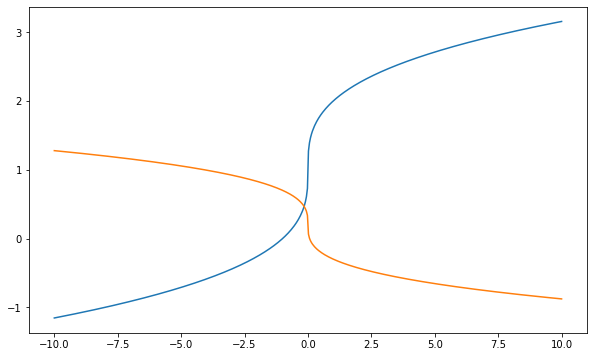

In [19]:
# Plot the inverse

plt.plot(x, cubic.inverse(x))
plt.show()

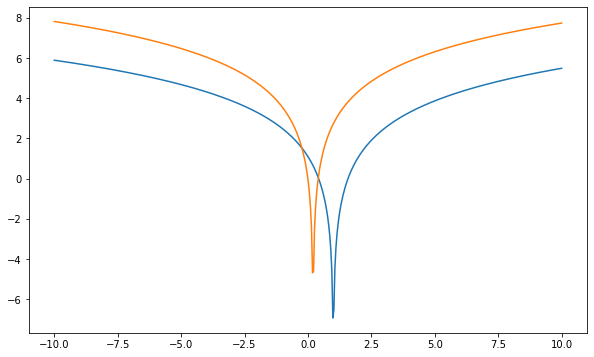

In [20]:
# Plot the forward log det jacobian determinant

plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))
plt.show()

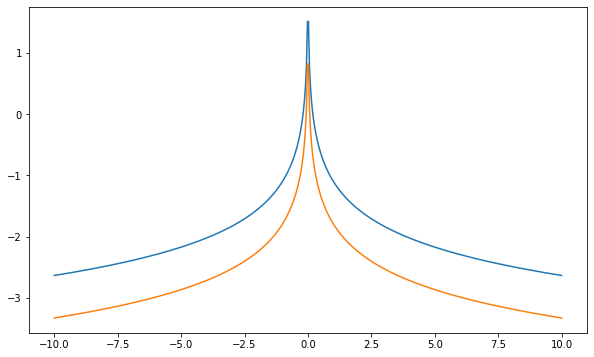

In [21]:
# Plot the inverse log Jacobian determinant

plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))
plt.show()

### TransformedDistribution and plots

In [22]:
# Create a transformed distribution with cubic

normal = tfd.Normal(loc=0., scale=1.)
cubed_normal = tfd.TransformedDistribution(tfd.Sample(normal, sample_shape=[2]), cubic)

In [23]:
# Sample cubed_normal

n = 1000
g = cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

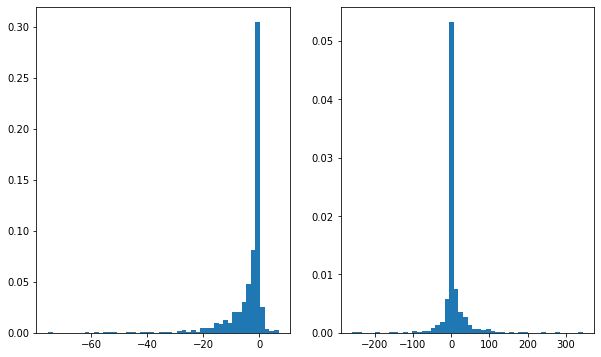

In [24]:
# Plot histogram

plt.subplot(1, 2, 1)
plt.hist(g[..., 0].numpy(), bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1].numpy(), bins=50, density=True)
plt.show()

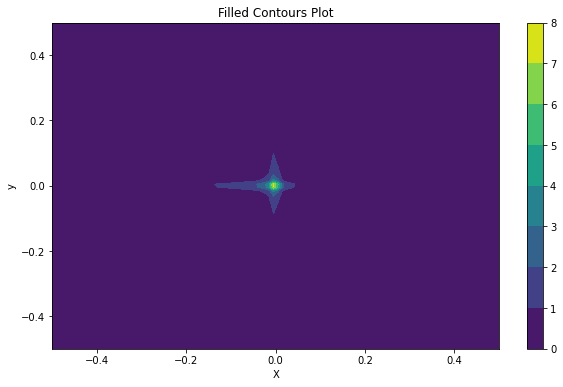

In [25]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1, 1)

Z = cubed_normal.prob(np.dstack((X, y)))
cp = ax.contourf(X, y, Z)

fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()

In [27]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = inverse_cubic(tfd.Sample(normal, sample_shape=[2]))

In [28]:
# Sample inv_cubed_normal

g = inv_cubed_normal.sample(n)
g.shape

TensorShape([1000, 2])

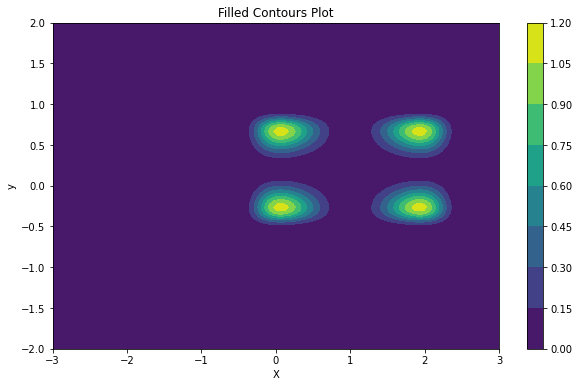

In [30]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, y = np.meshgrid(xx, yy)

fig, ax = plt.subplots(1, 1)

Z = inv_cubed_normal.prob(np.dstack((X, y)))
cp = ax.contourf(X, y, Z)

fig.colorbar(cp)
ax.set_title('Filled Contours Plot')
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()

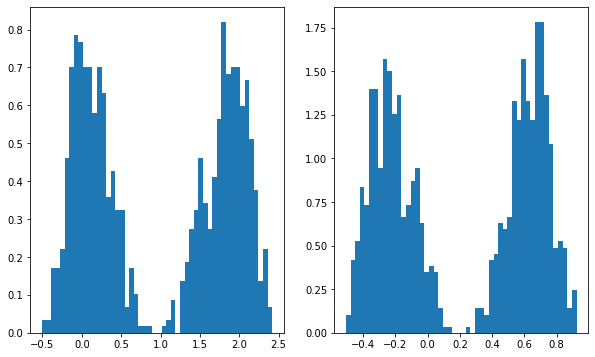

In [31]:
# Plot histogram

plt.subplot(1, 2, 1)
plt.hist(g[..., 0].numpy(), bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1].numpy(), bins=50, density=True)
plt.show()

### Training the bijector

In [32]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]

mix_gauss = tfd.Mixture(
    cat=tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-0.8, scale=0.4)
    ]
)

In [33]:
# Create the dataset

X_train = mix_gauss.sample(10000)
X_train = tf.data.Dataset.from_tensor_slices(X_train).batch(128)

X_valid = mix_gauss.sample(10000)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid).batch(128)

In [34]:
print(X_train.element_spec)
print(X_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


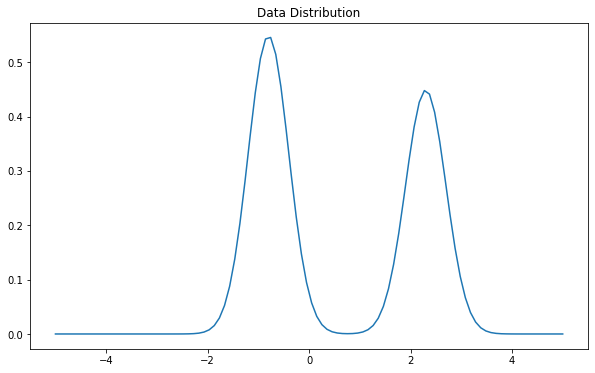

In [35]:
# Plot the data distribution

x = np.linspace(-5.0, 5.0, 100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data Distribution')
plt.show()

In [36]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25), tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [37]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

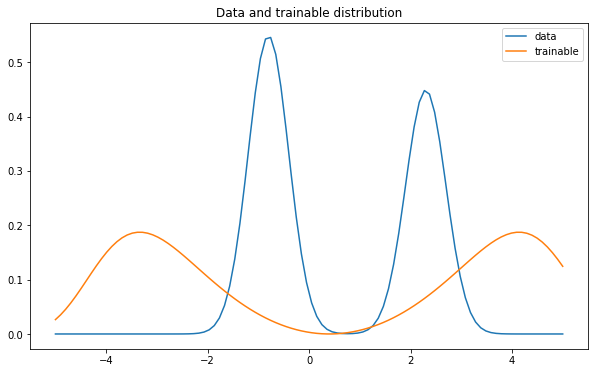

In [38]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)

plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='trainable')
plt.title('Data and trainable distribution')
plt.legend(loc='best')
plt.show()

In [40]:
# Train the bijector

num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


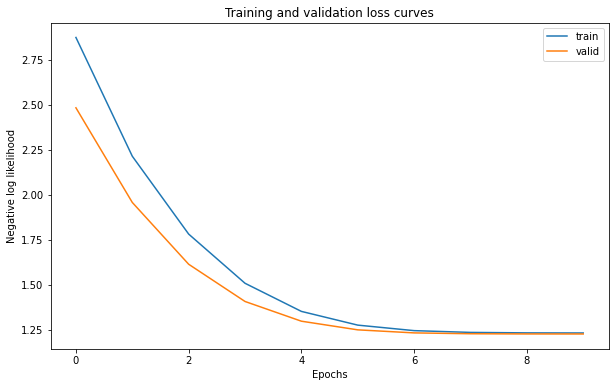

In [41]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

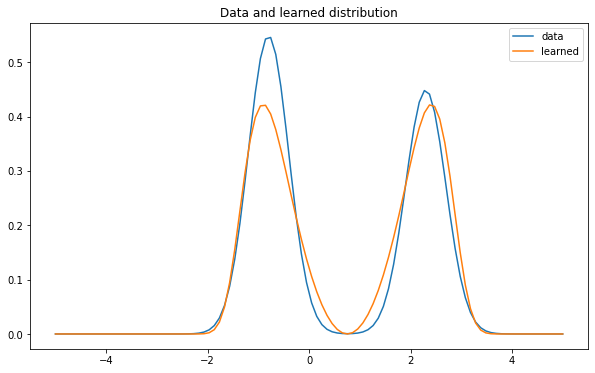

In [42]:
# Plot the data and learned distributions

x = np.linspace(-5.0, 5.0, 100)

plt.plot(x, mix_gauss.prob(x), label='data')
plt.plot(x, trainable_dist.prob(x), label='learned')
plt.title('Data and learned distribution')
plt.legend(loc='best')
plt.show()

In [43]:
# Display trainable variable
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.56402117>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.42473608>)